In [1]:
# Install TA-Lib C library
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%cd ..

# Install the Python wrapper for TA-Lib
!pip install TA-Lib

--2025-08-11 16:54:46--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:c95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-08-11 16:54:46--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://netactuate.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2025-08-11 16:54:46--  http://netactuate.dl.

In [1]:
!pip install alpha_vantage   ta xgboost

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 104.1 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=22f537ae2b2f2d0d9148d9ea07f4c88ffcc6feb2ffaf36c35c7c3d7dccbc3e95
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [3]:
!pip install BorutaShapPlus

In [ ]:
# Multi-Stock Long/Short Trading Strategy with Transformer and BorutaShap

import sys
import numpy as np
import pandas as pd
import math
import warnings
warnings.filterwarnings('ignore')

# Data fetching and processing
import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from datetime import datetime, timedelta
import time

# Feature engineering
from ta import add_all_ta_features
from ta.utils import dropna
import talib

# Feature selection
from BorutaShap import BorutaShap
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Model building
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

# Backtesting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
# Access API key from Colab secrets
from google.colab import userdata
API_KEY = userdata.get('API_KEY')
import random

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        # The two lines below can slow down training but ensure reproducibility
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function to set the seed for the entire script
set_seed(42)

print("Libraries imported successfully!")

In [ ]:
# ==========================================
# 1. STOCK UNIVERSE DEFINITION
# ==========================================

# Define stock universe - mix of sectors for diversification
STOCK_UNIVERSE = {
    'Technology': ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'META','TSLA'],
    'Finance': ['JPM', 'BAC', 'GS', 'WFC', 'MS','AMZN']

}

# Flatten stock list
ALL_STOCKS = [stock for sector_stocks in STOCK_UNIVERSE.values() for stock in sector_stocks]

print(f"Stock Universe: {len(ALL_STOCKS)} stocks across {len(STOCK_UNIVERSE)} sectors")

# ==========================================
# 2. DATA FETCHING WITH ALPHA VANTAGE
# ==========================================


def fetch_alpha_vantage_data(symbol, api_key, outputsize='full'):
    """
    Fetch data using Alpha Vantage API with technical indicators
    """
    ts = TimeSeries(key=api_key, output_format='pandas')
    ti = TechIndicators(key=api_key, output_format='pandas')

    try:
        # Get daily adjusted prices
        daily_data, _ = ts.get_daily_adjusted(symbol=symbol, outputsize=outputsize)
        time.sleep(0.8)  # Alpha Vantage rate limit

        # Get technical indicators
        sma_20, _ = ti.get_sma(symbol=symbol, interval='daily', time_period=20)
        time.sleep(0.8)

        rsi, _ = ti.get_rsi(symbol=symbol, interval='daily', time_period=14)
        time.sleep(0.8)

        macd, _ = ti.get_macd(symbol=symbol, interval='daily')
        time.sleep(0.8)

        # Combine data
        daily_data = daily_data.sort_index()
        daily_data.columns = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'Dividend', 'Split']

        # Add technical indicators
        daily_data['SMA_20'] = sma_20['SMA'].reindex(daily_data.index)
        daily_data['RSI'] = rsi['RSI'].reindex(daily_data.index)

        if not macd.empty:
            daily_data['MACD'] = macd['MACD'].reindex(daily_data.index)
            daily_data['MACD_Signal'] = macd['MACD_Signal'].reindex(daily_data.index)
            daily_data['MACD_Hist'] = macd['MACD_Hist'].reindex(daily_data.index)

        return daily_data

    except Exception as e:
        print(f"Error fetching {symbol} from Alpha Vantage: {e}")
        return None

def fetch_all_stocks_data(stocks, start_date='2004-01-01', end_date='2024-12-31', use_alpha_vantage=True):
    """
    Fetch data for all stocks using either Alpha Vantage or yfinance
    """
    stock_data = {}

    if use_alpha_vantage and API_KEY:
        print("Using Alpha Vantage API for enhanced data...")
        for i, stock in enumerate(stocks):
            print(f"Fetching {stock} ({i+1}/{len(stocks)})...")
            data = fetch_alpha_vantage_data(stock, API_KEY)
            if data is not None:
                # Filter by date range
                data = data[(data.index >= start_date) & (data.index <= end_date)]
                stock_data[stock] = data
            else:
                # Fallback to yfinance
                print(f"Falling back to yfinance for {stock}")
                data = yf.download(stock, start=start_date, end=end_date, progress=False)
                stock_data[stock] = data
    else:
        print("Using yfinance for data fetching...")
        for stock in stocks:
            data = yf.download(stock, start=start_date, end=end_date, progress=False)
            stock_data[stock] = data

    # Also fetch market indices for context
    spy = yf.download('SPY', start=start_date, end=end_date, progress=False)
    vix = yf.download('^VIX', start=start_date, end=end_date, progress=False)

    return stock_data, spy, vix


In [ ]:
# ==========================================
# 3. FEATURE ENGINEERING
# ==========================================

def create_advanced_features(df, symbol):
    """
    Create comprehensive technical features for each stock
    RETURNS-BASED approach for better ML performance
    """
    features = pd.DataFrame(index=df.index)

    # =======================================
    # CORE RETURNS FEATURES (Most Important)
    # =======================================

    # Simple returns
    features[f'{symbol}_returns_1d'] = df['Close'].pct_change()
    features[f'{symbol}_returns_2d'] = df['Close'].pct_change(2)
    features[f'{symbol}_returns_5d'] = df['Close'].pct_change(5)
    features[f'{symbol}_returns_10d'] = df['Close'].pct_change(10)
    features[f'{symbol}_returns_20d'] = df['Close'].pct_change(20)

    # Log returns (better for compounding)
    features[f'{symbol}_log_returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Overnight returns (gap)
    features[f'{symbol}_overnight_returns'] = df['Open'] / df['Close'].shift(1) - 1

    # Intraday returns
    features[f'{symbol}_intraday_returns'] = df['Close'] / df['Open'] - 1

    # High-Low returns (range)
    features[f'{symbol}_range_returns'] = df['High'] / df['Low'] - 1

    # =======================================
    # VOLATILITY FEATURES (Risk Metrics)
    # =======================================

    # Historical volatility (different windows)
    for period in [5, 10, 20, 60]:
        features[f'{symbol}_volatility_{period}d'] = features[f'{symbol}_returns_1d'].rolling(period).std()
        features[f'{symbol}_volatility_{period}d_annualized'] = features[f'{symbol}_volatility_{period}d'] * np.sqrt(252)

    # Parkinson volatility (using high-low)
    features[f'{symbol}_parkinson_vol'] = np.sqrt(
        np.log(df['High'] / df['Low']) ** 2 / (4 * np.log(2))
    ).rolling(20).mean()

    # Garman-Klass volatility (more efficient)
    features[f'{symbol}_gk_vol'] = np.sqrt(
        0.5 * np.log(df['High'] / df['Low']) ** 2 -
        (2 * np.log(2) - 1) * np.log(df['Close'] / df['Open']) ** 2
    ).rolling(20).mean()

    # Volatility ratio (short/long)
    features[f'{symbol}_vol_ratio'] = features[f'{symbol}_volatility_10d'] / features[f'{symbol}_volatility_60d']

    # =======================================
    # MOMENTUM FEATURES (Trend Indicators)
    # =======================================

    # Returns momentum (different lookbacks)
    for period in [5, 10, 20, 60, 120]:
        features[f'{symbol}_momentum_{period}d'] = df['Close'] / df['Close'].shift(period) - 1

    # Moving average of returns
    for period in [5, 10, 20]:
        features[f'{symbol}_returns_ma_{period}d'] = features[f'{symbol}_returns_1d'].rolling(period).mean()

    # Exponential moving average of returns
    for period in [5, 10, 20]:
        features[f'{symbol}_returns_ema_{period}d'] = features[f'{symbol}_returns_1d'].ewm(span=period, adjust=False).mean()

    # Rate of change
    features[f'{symbol}_roc_10d'] = (df['Close'] - df['Close'].shift(10)) / df['Close'].shift(10)
    features[f'{symbol}_roc_20d'] = (df['Close'] - df['Close'].shift(20)) / df['Close'].shift(20)

    # =======================================
    # MEAN REVERSION FEATURES
    # =======================================

    # Z-score of returns
    for period in [20, 60]:
        mean = features[f'{symbol}_returns_1d'].rolling(period).mean()
        std = features[f'{symbol}_returns_1d'].rolling(period).std()
        features[f'{symbol}_returns_zscore_{period}d'] = (features[f'{symbol}_returns_1d'] - mean) / std

    # Distance from moving average (in return space)
    for period in [20, 50, 200]:
        ma = df['Close'].rolling(period).mean()
        features[f'{symbol}_distance_from_ma_{period}'] = (df['Close'] - ma) / ma

    # =======================================
    # TECHNICAL INDICATORS (Returns-adjusted)
    # =======================================

    # RSI on returns (more stable than price RSI)
    def calculate_rsi(returns, period=14):
        gains = returns.where(returns > 0, 0)
        losses = -returns.where(returns < 0, 0)
        avg_gains = gains.rolling(period).mean()
        avg_losses = losses.rolling(period).mean()
        rs = avg_gains / avg_losses
        rsi = 100 - (100 / (1 + rs))
        return rsi

    features[f'{symbol}_rsi_returns_14'] = calculate_rsi(features[f'{symbol}_returns_1d'], 14)
    features[f'{symbol}_rsi_returns_30'] = calculate_rsi(features[f'{symbol}_returns_1d'], 30)

    # Bollinger Bands on returns
    for period in [20, 50]:
        returns_mean = features[f'{symbol}_returns_1d'].rolling(period).mean()
        returns_std = features[f'{symbol}_returns_1d'].rolling(period).std()
        features[f'{symbol}_bb_upper_returns_{period}'] = returns_mean + (returns_std * 2)
        features[f'{symbol}_bb_lower_returns_{period}'] = returns_mean - (returns_std * 2)
        features[f'{symbol}_bb_position_returns_{period}'] = (
            (features[f'{symbol}_returns_1d'] - features[f'{symbol}_bb_lower_returns_{period}']) /
            (features[f'{symbol}_bb_upper_returns_{period}'] - features[f'{symbol}_bb_lower_returns_{period}'])
        )

    # MACD on returns
    exp12 = features[f'{symbol}_returns_1d'].ewm(span=12, adjust=False).mean()
    exp26 = features[f'{symbol}_returns_1d'].ewm(span=26, adjust=False).mean()
    features[f'{symbol}_macd_returns'] = exp12 - exp26
    features[f'{symbol}_macd_signal_returns'] = features[f'{symbol}_macd_returns'].ewm(span=9, adjust=False).mean()
    features[f'{symbol}_macd_hist_returns'] = features[f'{symbol}_macd_returns'] - features[f'{symbol}_macd_signal_returns']

    # =======================================
    # VOLUME-RETURNS INTERACTION
    # =======================================

    # Volume-weighted returns
    features[f'{symbol}_volume_weighted_returns'] = features[f'{symbol}_returns_1d'] * (df['Volume'] / df['Volume'].rolling(20).mean())

    # Dollar volume returns
    dollar_volume = df['Close'] * df['Volume']
    features[f'{symbol}_dollar_volume_returns'] = dollar_volume.pct_change()

    # Volume momentum
    features[f'{symbol}_volume_momentum'] = df['Volume'] / df['Volume'].shift(20) - 1

    # =======================================
    # RISK-ADJUSTED RETURNS
    # =======================================

    # Sharpe ratio (rolling)
    for period in [20, 60]:
        returns_mean = features[f'{symbol}_returns_1d'].rolling(period).mean()
        returns_std = features[f'{symbol}_returns_1d'].rolling(period).std()
        features[f'{symbol}_sharpe_{period}d'] = (returns_mean / returns_std) * np.sqrt(252)

    # Sortino ratio (downside risk only)
    for period in [20, 60]:
        returns_mean = features[f'{symbol}_returns_1d'].rolling(period).mean()
        downside_returns = features[f'{symbol}_returns_1d'].where(features[f'{symbol}_returns_1d'] < 0, 0)
        downside_std = downside_returns.rolling(period).std()
        features[f'{symbol}_sortino_{period}d'] = (returns_mean / downside_std) * np.sqrt(252)

    # Maximum drawdown (rolling)
    cumulative_returns = (1 + features[f'{symbol}_returns_1d']).cumprod()
    running_max = cumulative_returns.expanding().max()
    features[f'{symbol}_drawdown'] = (cumulative_returns - running_max) / running_max

    # =======================================
    # HIGHER MOMENTS (Distribution Shape)
    # =======================================

    # Skewness of returns
    features[f'{symbol}_skewness_20d'] = features[f'{symbol}_returns_1d'].rolling(20).skew()
    features[f'{symbol}_skewness_60d'] = features[f'{symbol}_returns_1d'].rolling(60).skew()

    # Kurtosis of returns
    features[f'{symbol}_kurtosis_20d'] = features[f'{symbol}_returns_1d'].rolling(20).kurt()
    features[f'{symbol}_kurtosis_60d'] = features[f'{symbol}_returns_1d'].rolling(60).kurt()

    # =======================================
    # MICROSTRUCTURE FEATURES
    # =======================================

    # Amihud illiquidity (returns per dollar volume)
    features[f'{symbol}_amihud_illiquidity'] = np.abs(features[f'{symbol}_returns_1d']) / (df['Close'] * df['Volume'] / 1e6)

    # Roll's spread estimator
    features[f'{symbol}_roll_spread'] = 2 * np.sqrt(-features[f'{symbol}_returns_1d'].rolling(20).cov(features[f'{symbol}_returns_1d'].shift(1)))

    # Kyle's lambda (price impact)
    features[f'{symbol}_kyle_lambda'] = features[f'{symbol}_returns_1d'] / np.log(df['Volume'] / df['Volume'].shift(1))

    # =======================================
    # AUTOCORRELATION FEATURES
    # =======================================

    # Autocorrelation of returns
    for lag in [1, 5, 10, 20]:
        features[f'{symbol}_returns_autocorr_{lag}d'] = features[f'{symbol}_returns_1d'].rolling(60).apply(
            lambda x: x.autocorr(lag=lag) if len(x) > lag else np.nan
        )

    # =======================================
    # REGIME FEATURES
    # =======================================

    # Bull/Bear regime (based on returns MA)
    features[f'{symbol}_regime_bull'] = (features[f'{symbol}_returns_ma_20d'] > 0).astype(int)
    features[f'{symbol}_regime_bear'] = (features[f'{symbol}_returns_ma_20d'] < 0).astype(int)

    # High/Low volatility regime
    median_vol = features[f'{symbol}_volatility_20d'].rolling(252).median()
    features[f'{symbol}_high_vol_regime'] = (features[f'{symbol}_volatility_20d'] > median_vol).astype(int)

    return features

def create_market_features(spy, vix):
    """
    Create market-wide features from SPY and VIX
    """
    market_features = pd.DataFrame(index=spy.index)

    # Market returns and volatility
    market_features['market_returns'] = spy['Close'].pct_change()
    market_features['market_volatility'] = market_features['market_returns'].rolling(20).std()
    market_features['vix'] = vix['Close'].reindex(spy.index, method='ffill')
    market_features['vix_sma_20'] = market_features['vix'].rolling(20).mean()
    market_features['vix_ratio'] = market_features['vix'] / market_features['vix_sma_20']

    # Market regime
    market_features['market_sma_50'] = spy['Close'].rolling(50).mean()
    market_features['market_sma_200'] = spy['Close'].rolling(200).mean()
    market_features['market_trend'] = (market_features['market_sma_50'] > market_features['market_sma_200']).astype(int)

    # Market momentum
    market_features['market_momentum_20'] = spy['Close'] / spy['Close'].shift(20) - 1
    market_features['market_momentum_60'] = spy['Close'] / spy['Close'].shift(60) - 1

    return market_features

def create_relative_features(stock_features, stocks):
    """
    Create relative strength features between stocks (RETURNS-BASED)
    """
    relative_features = pd.DataFrame(index=stock_features.index)

    # Calculate relative returns for each stock pair
    for i, stock1 in enumerate(stocks):
        for stock2 in stocks[i+1:]:
            # Relative returns (spread)
            if f'{stock1}_returns_1d' in stock_features.columns and f'{stock2}_returns_1d' in stock_features.columns:
                relative_features[f'{stock1}_vs_{stock2}_spread'] = (
                    stock_features[f'{stock1}_returns_1d'] - stock_features[f'{stock2}_returns_1d']
                )

                # Rolling correlation of returns
                relative_features[f'{stock1}_vs_{stock2}_corr_20d'] = (
                    stock_features[f'{stock1}_returns_1d'].rolling(20).corr(stock_features[f'{stock2}_returns_1d'])
                )

                # Beta (relative to pair)
                cov = stock_features[f'{stock1}_returns_1d'].rolling(60).cov(stock_features[f'{stock2}_returns_1d'])
                var = stock_features[f'{stock2}_returns_1d'].rolling(60).var()
                relative_features[f'{stock1}_vs_{stock2}_beta'] = cov / var

                # Relative momentum
                if f'{stock1}_momentum_20d' in stock_features.columns:
                    relative_features[f'{stock1}_vs_{stock2}_momentum'] = (
                        stock_features[f'{stock1}_momentum_20d'] - stock_features.get(f'{stock2}_momentum_20d', 0)
                    )

                # Relative volatility
                if f'{stock1}_volatility_20d' in stock_features.columns:
                    relative_features[f'{stock1}_vs_{stock2}_vol_ratio'] = (
                        stock_features[f'{stock1}_volatility_20d'] /
                        (stock_features.get(f'{stock2}_volatility_20d', 1) + 1e-8)
                    )

    # Sector relative strength using returns
    for sector, sector_stocks in STOCK_UNIVERSE.items():
        sector_returns = pd.DataFrame()
        for stock in sector_stocks:
            if stock in stocks and f'{stock}_returns_1d' in stock_features.columns:
                sector_returns[stock] = stock_features[f'{stock}_returns_1d']

        if not sector_returns.empty:
            # Sector average return
            sector_mean_return = sector_returns.mean(axis=1)
            sector_median_return = sector_returns.median(axis=1)

            for stock in sector_stocks:
                if stock in stocks:
                    # Stock vs sector mean
                    relative_features[f'{stock}_vs_{sector}_mean_spread'] = (
                        stock_features[f'{stock}_returns_1d'] - sector_mean_return
                    )

                    # Stock vs sector median (more robust)
                    relative_features[f'{stock}_vs_{sector}_median_spread'] = (
                        stock_features[f'{stock}_returns_1d'] - sector_median_return
                    )

                    # Rank within sector
                    relative_features[f'{stock}_{sector}_rank'] = sector_returns.rank(axis=1, pct=True)[stock]

    # Market beta for each stock
    if 'market_returns' in stock_features.columns:
        for stock in stocks:
            if f'{stock}_returns_1d' in stock_features.columns:
                cov = stock_features[f'{stock}_returns_1d'].rolling(60).cov(stock_features['market_returns'])
                var = stock_features['market_returns'].rolling(60).var()
                relative_features[f'{stock}_market_beta'] = cov / var

                # Alpha (returns above market)
                relative_features[f'{stock}_alpha'] = (
                    stock_features[f'{stock}_returns_1d'] -
                    relative_features[f'{stock}_market_beta'] * stock_features['market_returns']
                )

    return relative_features

# ==========================================
# 4. TARGET CREATION FOR LONG/SHORT
# ==========================================

def create_targets(stock_data, stocks, forward_days=5):
    """
    Create targets for long/short positions
    Returns: 1 for long, -1 for short, 0 for neutral
    """
    # Find common index across all stocks to avoid misalignment
    common_index = None
    for stock in stocks:
        if common_index is None:
            common_index = stock_data[stock].index
        else:
            common_index = common_index.intersection(stock_data[stock].index)

    # Initialize targets DataFrame with common index
    targets = pd.DataFrame(index=common_index)

    for stock in stocks:
        # Reindex stock data to common index
        stock_df = stock_data[stock].reindex(common_index)
        # Calculate forward returns
        forward_returns = stock_df['Close'].shift(-forward_days) / stock_df['Close'] - 1
        # Initialize signal column
        targets[f'{stock}_signal'] = 0
        # Use index-aligned boolean indexing
        targets.loc[forward_returns > 0.02, f'{stock}_signal'] = 1
        targets.loc[forward_returns < -0.02, f'{stock}_signal'] = -1
        # Store forward returns
        targets[f'{stock}_forward_returns'] = forward_returns

    # Fill NaN signals with 0 (neutral)
    targets = targets.fillna(0)
    return targets

In [ ]:
# ==========================================
# 5. BORUTASHAP FEATURE SELECTION
# ==========================================


def apply_boruta_shap(X_train, y_train, stock_name):
    """
     BorutaShap using a GPU-accelerated XGBoost model.
    """
    print(f"\nApplying BorutaShap for {stock_name} using XGBoost on GPU...")

    
    gpu_model = XGBRegressor(tree_method='gpu_hist',
                             objective='reg:squarederror',
                             n_estimators=50,
                             random_state=42)

    # 2. Pass the GPU model into the BorutaShap selector.
    selector = BorutaShap(model=gpu_model,
                          importance_measure='shap',
                          classification=False)
    # ----------------------------

    selector.fit(X=X_train, y=y_train, n_trials=20, sample=True, verbose=False)

    # --- Feature Retrieval  ---
    accepted_features = selector.accepted
    tentative_features = selector.tentative
    final_features = accepted_features + tentative_features

    # We will return an empty DataFrame for importances for compatibility.
    feature_importance_df = pd.DataFrame()

    print(f"  - Features selected: {len(final_features)}")

    return final_features, selector, feature_importance_df


In [ ]:
# ==========================================
# 6. TRANSFORMER MODEL
# ==========================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

class StockTransformer(nn.Module):
    """
    Transformer model for stock prediction
    """
    def __init__(self, input_dim, hidden_dim=128, num_heads=8, num_layers=4, dropout=0.1):
        super(StockTransformer, self).__init__()

        # Input projection
        self.input_projection = nn.Linear(input_dim, hidden_dim)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model=hidden_dim, max_len=5000) # Use the new class

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim // 2, 3)  # 3 classes: long, short, neutral

        # Batch normalization
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim // 2)

    def forward(self, x):
        # Input shape: (batch_size, sequence_length, input_dim)

        # Project input
        x = self.input_projection(x)

        # Add positional encoding
        # Note: PyTorch Transformer expects (seq_len, batch_size, features)
        x = x.permute(1, 0, 2) # Permute to (seq_len, batch_size, features)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2) # Permute back to (batch_size, seq_len, features)

        # Apply transformer
        x = self.transformer(x)

        # Global average pooling
        x = x.mean(dim=1)

        # Apply batch normalization
        x = self.batch_norm1(x)

        # Output layers
        x = torch.relu(self.fc1(x))
        x = self.batch_norm2(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

def prepare_sequences(features, targets, sequence_length=60):
    """
    Prepare sequences for transformer input
    """
    X_sequences = []
    y_sequences = []

    for i in range(sequence_length, len(features) - 1):
        X_sequences.append(features[i-sequence_length:i])
        y_sequences.append(targets[i])

    return np.array(X_sequences), np.array(y_sequences)

def train_transformer(X_train_seq, y_train_seq, X_val_seq, y_val_seq, input_dim, y_train_full, stock,
                     epochs=30, batch_size=32, patience=10, min_delta=0.0001):
    """
    Train the model with a weighted loss, improved Early Stopping, and proper loss tracking.
    Args:
        X_train_seq (np.array): Training sequences (shape: samples x sequence_length x input_dim).
        y_train_seq (np.array): Training targets (shape: samples, values in [-1, 0, 1]).
        X_val_seq (np.array): Validation sequences.
        y_val_seq (np.array): Validation targets.
        input_dim (int): Number of input features.
        y_train_full (np.array): Full training targets for class weight calculation.
        stock (str): Stock ticker for logging and model saving.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        patience (int): Epochs to wait before early stopping.
        min_delta (float): Minimum improvement in validation loss.
    Returns:
        model: Trained StockTransformer model.
        train_losses (list): Training loss per epoch.
        val_losses (list): Validation loss per epoch.
    """
    import matplotlib.pyplot as plt
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nTraining {stock} on {device}")

    # Validate inputs
    if np.any(np.isnan(X_train_seq)) or np.any(np.isnan(X_val_seq)):
        raise ValueError(f"NaNs detected in input data for {stock}")
    if not np.all(np.isin(y_train_seq, [-1, 0, 1])) or not np.all(np.isin(y_val_seq, [-1, 0, 1])):
        raise ValueError(f"Invalid target values for {stock}")

    # Calculate class weights
    y_train_labels = y_train_seq + 1
    if not np.all(np.isin(y_train_full, [-1, 0, 1])):
        raise ValueError(f"Invalid target values in y_train_full for {stock}: {np.unique(y_train_full)}")
    class_counts = np.bincount(y_train_labels, minlength=3)
    class_weights = 1. / (torch.tensor(class_counts, dtype=torch.float) + 1e-6)
    class_weights = class_weights.to(device)
    print(f" - Using class weights: {class_weights.cpu().numpy()}")

    # Model, criterion, optimizer
    model = StockTransformer(
        input_dim=input_dim,
        hidden_dim=128,
        num_heads=8,
        num_layers=4,
        dropout=0.1
    ).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs*2)

    # Data tensors and loader
    X_train_tensor = torch.FloatTensor(X_train_seq).to(device)
    y_train_tensor = torch.LongTensor(y_train_seq + 1).to(device)
    X_val_tensor = torch.FloatTensor(X_val_seq).to(device)
    y_val_tensor = torch.LongTensor(y_val_seq + 1).to(device)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Early stopping and loss tracking
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()

        epoch_train_loss = train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        val_losses.append(val_loss)

        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}, Epochs No Improve: {epochs_no_improve}")

        # Early stopping
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            torch.save(best_model_state, f'best_model_{stock}.pth')
            epochs_no_improve = 0
            print(f" -> Validation loss improved to {best_val_loss:.4f}. Saving model.")
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs with no improvement.")
            break

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'Training and Validation Loss for {stock}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Load best model state
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model state with validation loss {best_val_loss:.4f}.")
    return model, train_losses, val_losses

         # Return empty lists for losses as they are not used elsewhere


In [ ]:
# ==========================================
# 7. PORTFOLIO CONSTRUCTION
# ==========================================

class LongShortPortfolio:
    """
    Long/Short portfolio management
    """
    def __init__(self, models, selected_features, scalers, stocks):
        self.models = models
        self.selected_features = selected_features
        self.scalers = scalers
        self.stocks = stocks
        self.positions = {stock: 0 for stock in stocks}
        self.portfolio_value = []
        self.trades = []

    def predict_signals(self, features, sequence_length=60):
        """
        Predict long/short signals for all stocks
        """
        predictions = {}
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        for stock in self.stocks:
            if stock in self.models:
                model = self.models[stock]
                model.eval()

                # Select and scale features
                stock_features = features[self.selected_features[stock]].values
                stock_features = self.scalers[stock].transform(stock_features)

                # Create sequence
                if len(stock_features) >= sequence_length:
                    sequence = stock_features[-sequence_length:].reshape(1, sequence_length, -1)
                    sequence_tensor = torch.FloatTensor(sequence).to(device)

                    # Predict
                    with torch.no_grad():
                        output = model(sequence_tensor)
                        probs = torch.softmax(output, dim=1)
                        pred_class = torch.argmax(probs, dim=1).item() - 1  # Convert back to -1, 0, 1
                        confidence = probs[0, torch.argmax(probs, dim=1)].item()

                    predictions[stock] = {
                        'signal': pred_class,
                        'confidence': confidence
                    }
                else:
                    predictions[stock] = {'signal': 0, 'confidence': 0}

        return predictions

    def select_top_positions(self, predictions, num_long=5, num_short=5):
        """
        Select top stocks for long and short positions based on confidence
        """
        long_candidates = [(stock, pred['confidence'])
                          for stock, pred in predictions.items()
                          if pred['signal'] == 1]
        short_candidates = [(stock, pred['confidence'])
                           for stock, pred in predictions.items()
                           if pred['signal'] == -1]

        # Sort by confidence
        long_candidates.sort(key=lambda x: x[1], reverse=True)
        short_candidates.sort(key=lambda x: x[1], reverse=True)

        # Select top positions
        long_stocks = [stock for stock, _ in long_candidates[:num_long]]
        short_stocks = [stock for stock, _ in short_candidates[:num_short]]

        return long_stocks, short_stocks

    def rebalance_portfolio(self, long_stocks, short_stocks, current_prices, capital=1000000):
        """
        Rebalance portfolio with equal weight for long and short positions
        """
        new_positions = {stock: 0 for stock in self.stocks}

        # Allocate capital: 50% for longs, 50% for shorts
        long_capital = capital * 0.5
        short_capital = capital * 0.5

        # Equal weight within long and short baskets
        if long_stocks:
            long_allocation = long_capital / len(long_stocks)
            for stock in long_stocks:
                new_positions[stock] = long_allocation / current_prices[stock]

        if short_stocks:
            short_allocation = short_capital / len(short_stocks)
            for stock in short_stocks:
                new_positions[stock] = -short_allocation / current_prices[stock]

        # Record trades
        for stock in self.stocks:
            if new_positions[stock] != self.positions[stock]:
                self.trades.append({
                    'stock': stock,
                    'old_position': self.positions[stock],
                    'new_position': new_positions[stock],
                    'price': current_prices[stock]
                })

        self.positions = new_positions

        return new_positions


In [ ]:
# ==========================================
# 8. BACKTESTING ENGINE
# ==========================================

def backtest_strategy(stock_data, models, selected_features, scalers, stocks,
                      test_start='2024-01-01', test_end='2024-12-31'):
    """
    Backtest the long/short strategy with corrected portfolio logic, risk management, and transaction costs.
    """
    print("\n" + "="*50)
    print("BACKTESTING STRATEGY")
    print("="*50)

    portfolio = LongShortPortfolio(models, selected_features, scalers, stocks)

    # --- Backtest Setup ---
    initial_capital = 1_000_000.0
    cash = initial_capital
    positions = {stock: 0 for stock in stocks}  # Stores number of shares held
    portfolio_values = []
    daily_returns = []
    positions_history = []
    long_stocks_history = []
    short_stocks_history = []

    # --- Risk Management & Costs ---
    MAX_POSITION_SIZE = 0.20  # Max 20% of equity in any single stock for 5 stocks
    MAX_LEVERAGE = 2.0      # Max 2x leverage (e.g., 100% long, 100% short)
    TRANSACTION_COST = 0.001 # 0.1% per trade

    # Prepare all features for the test period
    all_features = pd.DataFrame()
    for stock in stocks:
        if stock in stock_data:
            stock_features = create_advanced_features(stock_data[stock], stock)
            all_features = pd.concat([all_features, stock_features], axis=1)
    # 
    # 1. Interpolate to fill internal gaps with a straight line.
    all_features = all_features.interpolate(method='linear')
    # 2. Forward-fill to handle any remaining NaNs (e.g., at the very start).
    all_features = all_features.fillna(method='ffill')
    # 3. Back-fill as a final safety net.
    all_features = all_features.fillna(method='bfill')
    # 4. Any NaNs left would mean an entire column is empty, so drop it.
    all_features.dropna(axis=1, inplace=True)

    # Get the unique trading dates from the feature index within the test range
    test_dates = pd.to_datetime(all_features.loc[test_start:test_end].index.unique())

    if test_dates.empty:
        print("No data available for the specified backtest period.")
        return {}

    # --- Main Backtest Loop ---
    for i, date in enumerate(test_dates):
        current_prices = {s: stock_data[s].loc[date, 'Close'] for s in stocks if s in stock_data and date in stock_data[s].index}

        if not any(current_prices.values()):
            if portfolio_values:
                portfolio_values.append(portfolio_values[-1])
            continue

        # Mark-to-market: Calculate current portfolio value before any trades
        current_position_value = sum(positions.get(s, 0) * current_prices.get(s, 0) for s in stocks if s in current_prices)
        total_equity = cash + current_position_value

        if len(portfolio_values) > 0 and portfolio_values[-1] != 0:
            daily_return = (total_equity - portfolio_values[-1]) / portfolio_values[-1]
            daily_returns.append(daily_return)

        portfolio_values.append(total_equity)
        positions_history.append(positions.copy())

        # Rebalance every 5 trading days
        if i % 5 == 0:
            print(f"\n{date.strftime('%Y-%m-%d')} Rebalancing... Current Equity: ${total_equity:,.2f}")
            predictions = portfolio.predict_signals(all_features.loc[:date])
            long_stocks, short_stocks = portfolio.select_top_positions(predictions)

            long_stocks_history.append(long_stocks)
            short_stocks_history.append(short_stocks)

            # --- Rebalancing Logic with Risk Limits & Costs ---
            # 1. Liquidate all existing positions and deduct costs
            for stock, shares in positions.items():
                if shares != 0 and stock in current_prices:
                    trade_value = abs(shares * current_prices[stock])
                    cash += shares * current_prices[stock]
                    cash -= trade_value * TRANSACTION_COST # Deduct cost for closing position
            positions = {s: 0 for s in stocks}

            # 2. Determine capital allocation based on leverage
            gross_exposure = total_equity * MAX_LEVERAGE
            long_capital = gross_exposure / 2
            short_capital = gross_exposure / 2

            # 3. Establish new long positions
            if long_stocks:
                alloc_per_long = long_capital / len(long_stocks)
                # Enforce max position size
                alloc_per_long = min(alloc_per_long, total_equity * MAX_POSITION_SIZE)

                for stock in long_stocks:
                    if stock in current_prices and current_prices[stock] > 0:
                        shares_to_buy = alloc_per_long / current_prices[stock]
                        positions[stock] = shares_to_buy
                        trade_value = shares_to_buy * current_prices[stock]
                        cash -= trade_value
                        cash -= trade_value * TRANSACTION_COST # Deduct cost for opening long

            # 4. Establish new short positions
            if short_stocks:
                alloc_per_short = short_capital / len(short_stocks)
                # Enforce max position size
                alloc_per_short = min(alloc_per_short, total_equity * MAX_POSITION_SIZE)

                for stock in short_stocks:
                    if stock in current_prices and current_prices[stock] > 0:
                        shares_to_short = alloc_per_short / current_prices[stock]
                        positions[stock] = -shares_to_short
                        trade_value = shares_to_short * current_prices[stock]
                        cash += trade_value
                        cash -= trade_value * TRANSACTION_COST # Deduct cost for opening short

    # --- Performance Calculation ---
    if not portfolio_values:
        print("Backtest generated no data to analyze.")
        return {}

    portfolio_returns_series = pd.Series(daily_returns)
    final_equity = portfolio_values[-1]

    total_return = (final_equity - initial_capital) / initial_capital
    annualized_return = (1 + total_return) ** (252 / len(portfolio_values)) - 1 if len(portfolio_values) > 0 else 0
    volatility = portfolio_returns_series.std() * np.sqrt(252) if len(portfolio_returns_series) > 1 else 0
    sharpe_ratio = annualized_return / volatility if volatility > 0 else 0

    portfolio_series = pd.Series(portfolio_values)
    rolling_max = portfolio_series.expanding().max()
    drawdown = (portfolio_series - rolling_max) / rolling_max
    max_drawdown = drawdown.min() if not drawdown.empty else 0

    win_rate = (portfolio_returns_series > 0).sum() / len(portfolio_returns_series) if len(portfolio_returns_series) > 0 else 0

    downside_returns = portfolio_returns_series[portfolio_returns_series < 0]
    downside_std = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 1 else 0
    sortino_ratio = annualized_return / downside_std if downside_std > 0 else 0

    # --- Print Results ---
    print("\n" + "="*50)
    print("BACKTEST RESULTS")
    print("="*50)
    print(f"Initial Capital:         ${initial_capital:,.2f}")
    print(f"Final Portfolio Value:   ${final_equity:,.2f}")
    print(f"Total Return:            {total_return:.2%}")
    print(f"Annualized Return:       {annualized_return:.2%}")
    print(f"Volatility:              {volatility:.2%}")
    print(f"Sharpe Ratio:            {sharpe_ratio:.3f}")
    print(f"Sortino Ratio:           {sortino_ratio:.3f}")
    print(f"Maximum Drawdown:        {max_drawdown:.2%}")
    print(f"Win Rate:                {win_rate:.2%}")

    # --- Return Results ---
    return {
        'portfolio_values': portfolio_values,
        'daily_returns': daily_returns,
        'positions_history': positions_history,
        'long_stocks_history': long_stocks_history,
        'short_stocks_history': short_stocks_history,
        'test_dates': test_dates,
        'metrics': {
            'total_return': total_return,
            'annualized_return': annualized_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'max_drawdown': max_drawdown,
            'win_rate': win_rate
        }
    }


In [ ]:

# ==========================================
# 9. VISUALIZATION
# ==========================================

def plot_backtest_results(backtest_results, spy_data, test_dates):
    """
    Create comprehensive visualization of backtest results
    """
    fig = make_subplots(
        rows=4, cols=2,
        subplot_titles=(
            'Portfolio Value Over Time', 'Daily Returns Distribution',
            'Cumulative Returns vs SPY', 'Drawdown',
            'Long Positions Frequency', 'Short Positions Frequency',
            'Rolling Sharpe Ratio', 'Monthly Returns Heatmap'
        ),
        specs=[
            [{'type': 'scatter'}, {'type': 'histogram'}],
            [{'type': 'scatter'}, {'type': 'scatter'}],
            [{'type': 'bar'}, {'type': 'bar'}],
            [{'type': 'scatter'}, {'type': 'scatter'}]
        ],
        vertical_spacing=0.1,
        horizontal_spacing=0.15
    )

    # Portfolio value
    dates = test_dates
    fig.add_trace(
        go.Scatter(x=dates, y=backtest_results['portfolio_values'], name='Portfolio Value'),
        row=1, col=1
    )

    # Daily returns distribution
    fig.add_trace(
        go.Histogram(x=backtest_results['daily_returns'], nbinsx=50, name='Daily Returns'),
        row=1, col=2
    )

    # Cumulative returns comparison
    portfolio_cumulative = (pd.Series(backtest_results['daily_returns']) + 1).cumprod()
    spy_returns = spy_data['Close'].pct_change().loc[dates.min():dates.max()]
    spy_cumulative = (spy_returns + 1).cumprod()

    fig.add_trace(
        go.Scatter(x=dates[:len(portfolio_cumulative)], y=portfolio_cumulative, name='Strategy'),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=spy_cumulative.index, y=spy_cumulative, name='SPY'),
        row=2, col=1
    )

    # Drawdown
    portfolio_series = pd.Series(backtest_results['portfolio_values'])
    rolling_max = portfolio_series.expanding().max()
    drawdown = (portfolio_series - rolling_max) / rolling_max

    fig.add_trace(
        go.Scatter(x=dates, y=drawdown, fill='tozeroy', name='Drawdown'),
        row=2, col=2
    )

    # Position frequencies
    all_long_stocks = [stock for sublist in backtest_results['long_stocks_history'] for stock in sublist]
    all_short_stocks = [stock for sublist in backtest_results['short_stocks_history'] for stock in sublist]

    long_freq = pd.Series(all_long_stocks).value_counts()
    short_freq = pd.Series(all_short_stocks).value_counts()

    fig.add_trace(
        go.Bar(x=long_freq.index, y=long_freq.values, name='Long Frequency'),
        row=3, col=1
    )

    fig.add_trace(
        go.Bar(x=short_freq.index, y=short_freq.values, name='Short Frequency'),
        row=3, col=2
    )

    # Rolling Sharpe ratio
    rolling_sharpe = []
    window = 20
    for i in range(window, len(backtest_results['daily_returns'])):
        window_returns = backtest_results['daily_returns'][i-window:i]
        if np.std(window_returns) > 0:
            sharpe = np.mean(window_returns) / np.std(window_returns) * np.sqrt(252)
        else:
            sharpe = 0
        rolling_sharpe.append(sharpe)

    fig.add_trace(
        go.Scatter(x=dates[window:window+len(rolling_sharpe)], y=rolling_sharpe, name='Rolling Sharpe'),
        row=4, col=1
    )

    # Update layout
    fig.update_layout(height=1600, showlegend=True, title_text="Long/Short Strategy Backtest Results")
    fig.update_xaxes(title_text="Date", row=4, col=1)
    fig.update_yaxes(title_text="Value", row=1, col=1)

    fig.show()

    # Additional performance plot
    fig2, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Equity curve
    axes[0, 0].plot(backtest_results['portfolio_values'])
    axes[0, 0].set_title('Portfolio Equity Curve')
    axes[0, 0].set_xlabel('Days')
    axes[0, 0].set_ylabel('Portfolio Value ($)')
    axes[0, 0].grid(True, alpha=0.3)

    # Returns distribution
    axes[0, 1].hist(backtest_results['daily_returns'], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
    axes[0, 1].set_title('Daily Returns Distribution')
    axes[0, 1].set_xlabel('Daily Return')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)

    # Q-Q plot
    stats.probplot(backtest_results['daily_returns'], dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot of Returns')
    axes[1, 0].grid(True, alpha=0.3)

    # Cumulative returns
    cumulative_returns = (pd.Series(backtest_results['daily_returns']) + 1).cumprod() - 1
    axes[1, 1].plot(cumulative_returns * 100)
    axes[1, 1].set_title('Cumulative Returns')
    axes[1, 1].set_xlabel('Days')
    axes[1, 1].set_ylabel('Cumulative Return (%)')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Libraries imported successfully!
Stock Universe: 12 stocks across 2 sectors
MULTI-STOCK LONG/SHORT TRANSFORMER STRATEGY

[Step 1] Fetching historical data...
Using Alpha Vantage API for enhanced data...
Fetching AAPL (1/12)...
Fetching MSFT (2/12)...
Fetching GOOGL (3/12)...
Fetching NVDA (4/12)...
Fetching META (5/12)...
Fetching TSLA (6/12)...
Fetching JPM (7/12)...
Fetching BAC (8/12)...
Fetching GS (9/12)...
Fetching WFC (10/12)...
Fetching MS (11/12)...
Fetching AMZN (12/12)...

[Step 2] Creating features...
  Processing features for AAPL...
  Processing features for MSFT...
  Processing features for GOOGL...
  Processing features for NVDA...
  Processing features for META...
  Processing features for TSLA...
  Processing features for JPM...
  Processing features for BAC...
  Processing features for GS...
  Processing features for WFC...
  Processing features for MS...
  Processing features for AMZN...
  Total features created: 1252

[Step 3] Creating targets and aligning data...


  0%|          | 0/20 [00:00<?, ?it/s]

  - Features selected: 21
  Training transformer for AAPL...

Training AAPL on cuda
 - Using class weights: [0.0016     0.00087184 0.00119048]
Epoch 1/30, Train Loss: 1.1098, Val Loss: 1.0980, Epochs No Improve: 0
 -> Validation loss improved to 1.0980. Saving model.
Epoch 2/30, Train Loss: 1.0362, Val Loss: 1.1360, Epochs No Improve: 0
Epoch 3/30, Train Loss: 1.0077, Val Loss: 1.0662, Epochs No Improve: 1
 -> Validation loss improved to 1.0662. Saving model.
Epoch 4/30, Train Loss: 0.9918, Val Loss: 1.0764, Epochs No Improve: 0
Epoch 5/30, Train Loss: 0.9524, Val Loss: 1.2221, Epochs No Improve: 1
Epoch 6/30, Train Loss: 0.9531, Val Loss: 1.2531, Epochs No Improve: 2
Epoch 7/30, Train Loss: 0.9306, Val Loss: 1.1442, Epochs No Improve: 3
Epoch 8/30, Train Loss: 0.9145, Val Loss: 1.1769, Epochs No Improve: 4
Epoch 9/30, Train Loss: 0.8877, Val Loss: 1.2809, Epochs No Improve: 5
Epoch 10/30, Train Loss: 0.8726, Val Loss: 1.4207, Epochs No Improve: 6
Epoch 11/30, Train Loss: 0.8616, Val L

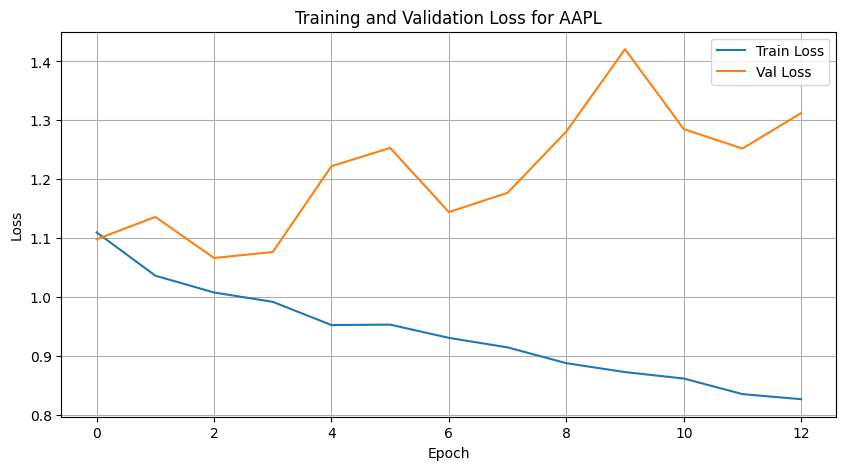


Loaded best model state with validation loss 1.0662.
  -> Model for AAPL saved to AAPL_transformer_model.pth

--- Processing MSFT ---
  Original feature count: 1252
  Pre-filtered to 200 features for BorutaShap.

Applying BorutaShap for MSFT using XGBoost on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

  - Features selected: 23
  Training transformer for MSFT...

Training MSFT on cuda
 - Using class weights: [0.0020284  0.0007326  0.00132626]
Epoch 1/30, Train Loss: 1.0722, Val Loss: 1.1291, Epochs No Improve: 0
 -> Validation loss improved to 1.1291. Saving model.
Epoch 2/30, Train Loss: 1.0204, Val Loss: 1.2098, Epochs No Improve: 0
Epoch 3/30, Train Loss: 1.0071, Val Loss: 1.2140, Epochs No Improve: 1
Epoch 4/30, Train Loss: 0.9966, Val Loss: 1.1911, Epochs No Improve: 2
Epoch 5/30, Train Loss: 0.9791, Val Loss: 1.2505, Epochs No Improve: 3
Epoch 6/30, Train Loss: 0.9671, Val Loss: 1.1393, Epochs No Improve: 4
Epoch 7/30, Train Loss: 0.9471, Val Loss: 1.1880, Epochs No Improve: 5
Epoch 8/30, Train Loss: 0.9430, Val Loss: 1.1998, Epochs No Improve: 6
Epoch 9/30, Train Loss: 0.9179, Val Loss: 1.1938, Epochs No Improve: 7
Epoch 10/30, Train Loss: 0.8878, Val Loss: 1.0929, Epochs No Improve: 8
 -> Validation loss improved to 1.0929. Saving model.
Epoch 11/30, Train Loss: 0.9023, Val L

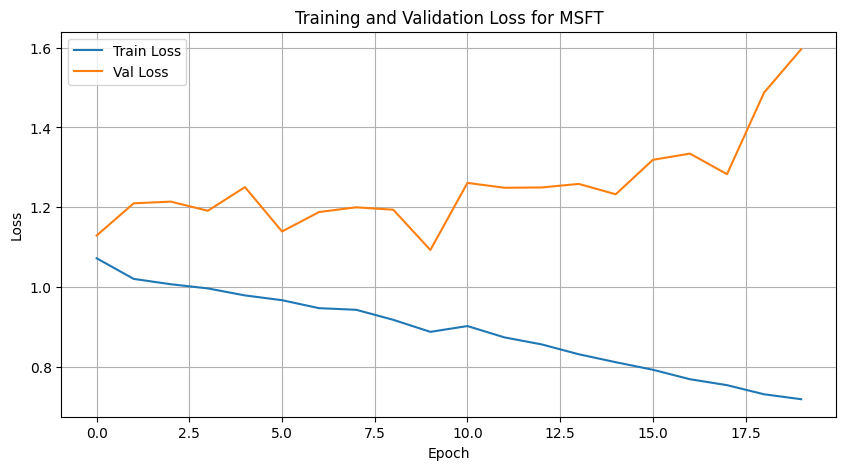


Loaded best model state with validation loss 1.0929.
  -> Model for MSFT saved to MSFT_transformer_model.pth

--- Processing GOOGL ---
  Original feature count: 1252
  Pre-filtered to 200 features for BorutaShap.

Applying BorutaShap for GOOGL using XGBoost on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

  - Features selected: 15
  Training transformer for GOOGL...

Training GOOGL on cuda
 - Using class weights: [0.00176367 0.00078555 0.00129534]
Epoch 1/30, Train Loss: 1.1097, Val Loss: 1.1618, Epochs No Improve: 0
 -> Validation loss improved to 1.1618. Saving model.
Epoch 2/30, Train Loss: 1.0687, Val Loss: 1.1978, Epochs No Improve: 0
Epoch 3/30, Train Loss: 1.0382, Val Loss: 1.2495, Epochs No Improve: 1
Epoch 4/30, Train Loss: 1.0208, Val Loss: 1.1699, Epochs No Improve: 2
Epoch 5/30, Train Loss: 1.0076, Val Loss: 1.2003, Epochs No Improve: 3
Epoch 6/30, Train Loss: 0.9888, Val Loss: 1.3661, Epochs No Improve: 4
Epoch 7/30, Train Loss: 0.9553, Val Loss: 1.4815, Epochs No Improve: 5
Epoch 8/30, Train Loss: 0.9430, Val Loss: 1.4690, Epochs No Improve: 6
Epoch 9/30, Train Loss: 0.9019, Val Loss: 1.6158, Epochs No Improve: 7
Epoch 10/30, Train Loss: 0.8845, Val Loss: 1.6697, Epochs No Improve: 8
Epoch 11/30, Train Loss: 0.8611, Val Loss: 1.6092, Epochs No Improve: 9

Early stopping tr

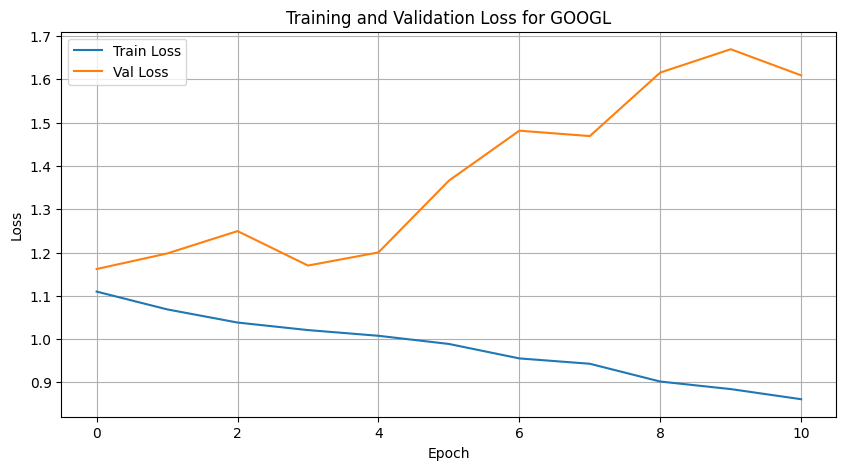


Loaded best model state with validation loss 1.1618.
  -> Model for GOOGL saved to GOOGL_transformer_model.pth

--- Processing NVDA ---
  Original feature count: 1252
  Pre-filtered to 200 features for BorutaShap.

Applying BorutaShap for NVDA using XGBoost on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

  - Features selected: 8
  BorutaShap selected too few features, falling back to top 30 correlated features.
  Training transformer for NVDA...

Training NVDA on cuda
 - Using class weights: [0.00143472 0.00112867 0.00097182]
Epoch 1/30, Train Loss: 1.1293, Val Loss: 1.1849, Epochs No Improve: 0
 -> Validation loss improved to 1.1849. Saving model.
Epoch 2/30, Train Loss: 1.0695, Val Loss: 1.1586, Epochs No Improve: 0
 -> Validation loss improved to 1.1586. Saving model.
Epoch 3/30, Train Loss: 1.0657, Val Loss: 1.2482, Epochs No Improve: 0
Epoch 4/30, Train Loss: 1.0451, Val Loss: 1.1489, Epochs No Improve: 1
 -> Validation loss improved to 1.1489. Saving model.
Epoch 5/30, Train Loss: 1.0290, Val Loss: 1.2167, Epochs No Improve: 0
Epoch 6/30, Train Loss: 1.0195, Val Loss: 1.1886, Epochs No Improve: 1
Epoch 7/30, Train Loss: 1.0092, Val Loss: 1.2301, Epochs No Improve: 2
Epoch 8/30, Train Loss: 0.9859, Val Loss: 1.1541, Epochs No Improve: 3
Epoch 9/30, Train Loss: 0.9626, Val Loss: 1.

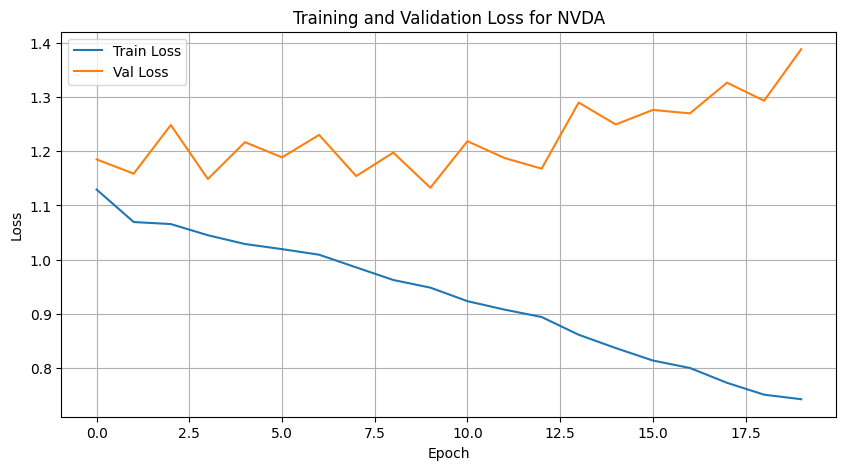


Loaded best model state with validation loss 1.1326.
  -> Model for NVDA saved to NVDA_transformer_model.pth

--- Processing META ---
  Original feature count: 1252
  Pre-filtered to 200 features for BorutaShap.

Applying BorutaShap for META using XGBoost on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

  - Features selected: 15
  Training transformer for META...

Training META on cuda
 - Using class weights: [0.00147059 0.00095511 0.00112994]
Epoch 1/30, Train Loss: 1.0967, Val Loss: 1.1430, Epochs No Improve: 0
 -> Validation loss improved to 1.1430. Saving model.
Epoch 2/30, Train Loss: 1.0351, Val Loss: 1.1532, Epochs No Improve: 0
Epoch 3/30, Train Loss: 1.0173, Val Loss: 1.0981, Epochs No Improve: 1
 -> Validation loss improved to 1.0981. Saving model.
Epoch 4/30, Train Loss: 0.9991, Val Loss: 1.2501, Epochs No Improve: 0
Epoch 5/30, Train Loss: 0.9824, Val Loss: 1.1270, Epochs No Improve: 1
Epoch 6/30, Train Loss: 0.9686, Val Loss: 1.3207, Epochs No Improve: 2
Epoch 7/30, Train Loss: 0.9500, Val Loss: 1.2389, Epochs No Improve: 3
Epoch 8/30, Train Loss: 0.9306, Val Loss: 1.4141, Epochs No Improve: 4
Epoch 9/30, Train Loss: 0.9192, Val Loss: 1.3774, Epochs No Improve: 5
Epoch 10/30, Train Loss: 0.9021, Val Loss: 1.3555, Epochs No Improve: 6
Epoch 11/30, Train Loss: 0.8852, Val L

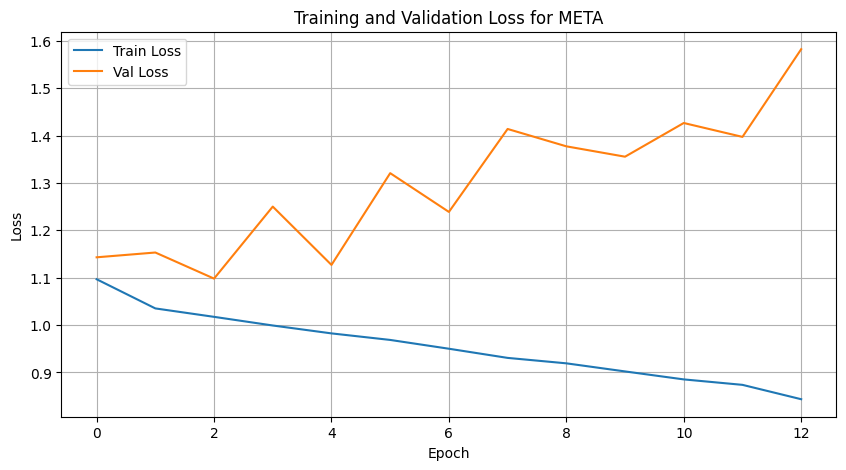


Loaded best model state with validation loss 1.0981.
  -> Model for META saved to META_transformer_model.pth

--- Processing TSLA ---
  Original feature count: 1252
  Pre-filtered to 200 features for BorutaShap.

Applying BorutaShap for TSLA using XGBoost on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

  - Features selected: 18
  Training transformer for TSLA...

Training TSLA on cuda
 - Using class weights: [0.00115207 0.00158228 0.00089928]
Epoch 1/30, Train Loss: 1.1237, Val Loss: 1.1971, Epochs No Improve: 0
 -> Validation loss improved to 1.1971. Saving model.
Epoch 2/30, Train Loss: 1.0754, Val Loss: 1.2246, Epochs No Improve: 0
Epoch 3/30, Train Loss: 1.0479, Val Loss: 1.2767, Epochs No Improve: 1
Epoch 4/30, Train Loss: 1.0352, Val Loss: 1.2683, Epochs No Improve: 2
Epoch 5/30, Train Loss: 1.0268, Val Loss: 1.3184, Epochs No Improve: 3
Epoch 6/30, Train Loss: 1.0080, Val Loss: 1.2811, Epochs No Improve: 4
Epoch 7/30, Train Loss: 0.9980, Val Loss: 1.3134, Epochs No Improve: 5
Epoch 8/30, Train Loss: 0.9795, Val Loss: 1.3712, Epochs No Improve: 6
Epoch 9/30, Train Loss: 0.9790, Val Loss: 1.3225, Epochs No Improve: 7
Epoch 10/30, Train Loss: 0.9624, Val Loss: 1.3659, Epochs No Improve: 8
Epoch 11/30, Train Loss: 0.9538, Val Loss: 1.4640, Epochs No Improve: 9

Early stopping trig

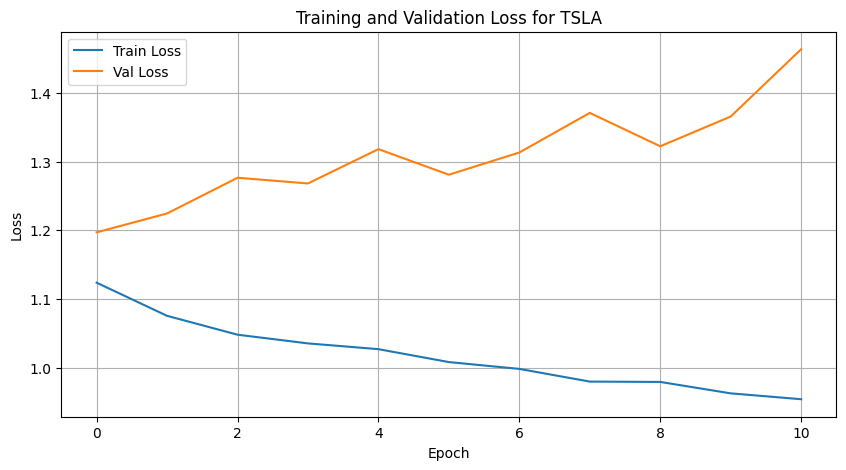


Loaded best model state with validation loss 1.1971.
  -> Model for TSLA saved to TSLA_transformer_model.pth

--- Processing JPM ---
  Original feature count: 1252
  Pre-filtered to 200 features for BorutaShap.

Applying BorutaShap for JPM using XGBoost on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

  - Features selected: 14
  Training transformer for JPM...

Training JPM on cuda
 - Using class weights: [0.0018622  0.00073692 0.00139276]
Epoch 1/30, Train Loss: 1.1190, Val Loss: 1.1503, Epochs No Improve: 0
 -> Validation loss improved to 1.1503. Saving model.
Epoch 2/30, Train Loss: 1.0708, Val Loss: 1.1833, Epochs No Improve: 0
Epoch 3/30, Train Loss: 1.0579, Val Loss: 1.1679, Epochs No Improve: 1
Epoch 4/30, Train Loss: 1.0338, Val Loss: 1.2645, Epochs No Improve: 2
Epoch 5/30, Train Loss: 1.0287, Val Loss: 1.1932, Epochs No Improve: 3
Epoch 6/30, Train Loss: 1.0005, Val Loss: 1.2403, Epochs No Improve: 4
Epoch 7/30, Train Loss: 1.0024, Val Loss: 1.2889, Epochs No Improve: 5
Epoch 8/30, Train Loss: 0.9848, Val Loss: 1.2510, Epochs No Improve: 6
Epoch 9/30, Train Loss: 0.9671, Val Loss: 1.2645, Epochs No Improve: 7
Epoch 10/30, Train Loss: 0.9485, Val Loss: 1.3719, Epochs No Improve: 8
Epoch 11/30, Train Loss: 0.9306, Val Loss: 1.3572, Epochs No Improve: 9

Early stopping trigge

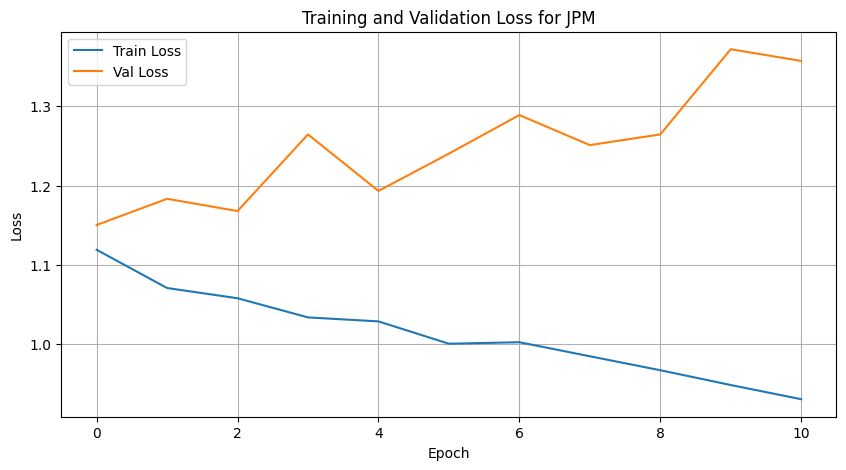


Loaded best model state with validation loss 1.1503.
  -> Model for JPM saved to JPM_transformer_model.pth

--- Processing BAC ---
  Original feature count: 1252
  Pre-filtered to 200 features for BorutaShap.

Applying BorutaShap for BAC using XGBoost on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

  - Features selected: 25
  Training transformer for BAC...

Training BAC on cuda
 - Using class weights: [0.00156495 0.00087796 0.00119904]
Epoch 1/30, Train Loss: 1.1161, Val Loss: 1.1247, Epochs No Improve: 0
 -> Validation loss improved to 1.1247. Saving model.
Epoch 2/30, Train Loss: 1.0631, Val Loss: 1.1382, Epochs No Improve: 0
Epoch 3/30, Train Loss: 1.0420, Val Loss: 1.1663, Epochs No Improve: 1
Epoch 4/30, Train Loss: 1.0308, Val Loss: 1.1669, Epochs No Improve: 2
Epoch 5/30, Train Loss: 1.0076, Val Loss: 1.1507, Epochs No Improve: 3
Epoch 6/30, Train Loss: 1.0005, Val Loss: 1.1890, Epochs No Improve: 4
Epoch 7/30, Train Loss: 0.9852, Val Loss: 1.2054, Epochs No Improve: 5
Epoch 8/30, Train Loss: 0.9751, Val Loss: 1.1915, Epochs No Improve: 6
Epoch 9/30, Train Loss: 0.9675, Val Loss: 1.2500, Epochs No Improve: 7
Epoch 10/30, Train Loss: 0.9405, Val Loss: 1.2410, Epochs No Improve: 8
Epoch 11/30, Train Loss: 0.9229, Val Loss: 1.3672, Epochs No Improve: 9

Early stopping trigge

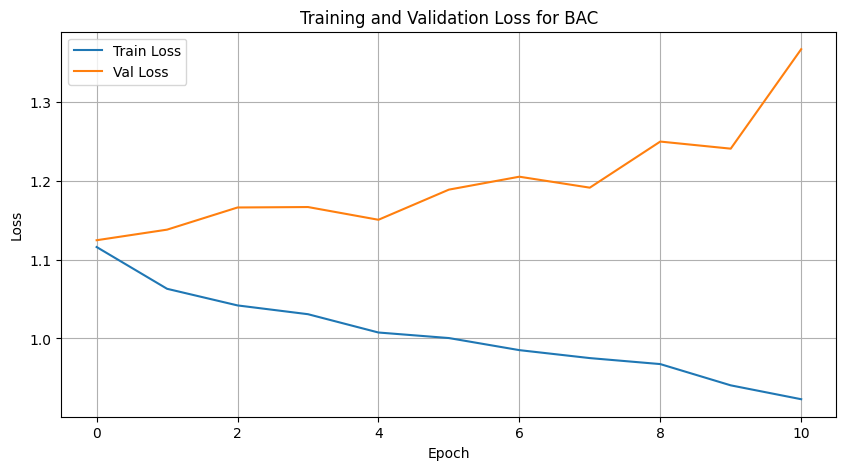


Loaded best model state with validation loss 1.1247.
  -> Model for BAC saved to BAC_transformer_model.pth

--- Processing GS ---
  Original feature count: 1252
  Pre-filtered to 200 features for BorutaShap.

Applying BorutaShap for GS using XGBoost on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

  - Features selected: 15
  Training transformer for GS...

Training GS on cuda
 - Using class weights: [0.0016129  0.00083333 0.00126263]
Epoch 1/30, Train Loss: 1.1192, Val Loss: 1.1303, Epochs No Improve: 0
 -> Validation loss improved to 1.1303. Saving model.
Epoch 2/30, Train Loss: 1.0658, Val Loss: 1.1362, Epochs No Improve: 0
Epoch 3/30, Train Loss: 1.0546, Val Loss: 1.0995, Epochs No Improve: 1
 -> Validation loss improved to 1.0995. Saving model.
Epoch 4/30, Train Loss: 1.0319, Val Loss: 1.1131, Epochs No Improve: 0
Epoch 5/30, Train Loss: 1.0282, Val Loss: 1.1778, Epochs No Improve: 1
Epoch 6/30, Train Loss: 1.0057, Val Loss: 1.1135, Epochs No Improve: 2
Epoch 7/30, Train Loss: 0.9925, Val Loss: 1.1582, Epochs No Improve: 3
Epoch 8/30, Train Loss: 0.9882, Val Loss: 1.1174, Epochs No Improve: 4
Epoch 9/30, Train Loss: 0.9682, Val Loss: 1.1592, Epochs No Improve: 5
Epoch 10/30, Train Loss: 0.9695, Val Loss: 1.1990, Epochs No Improve: 6
Epoch 11/30, Train Loss: 0.9459, Val Loss:

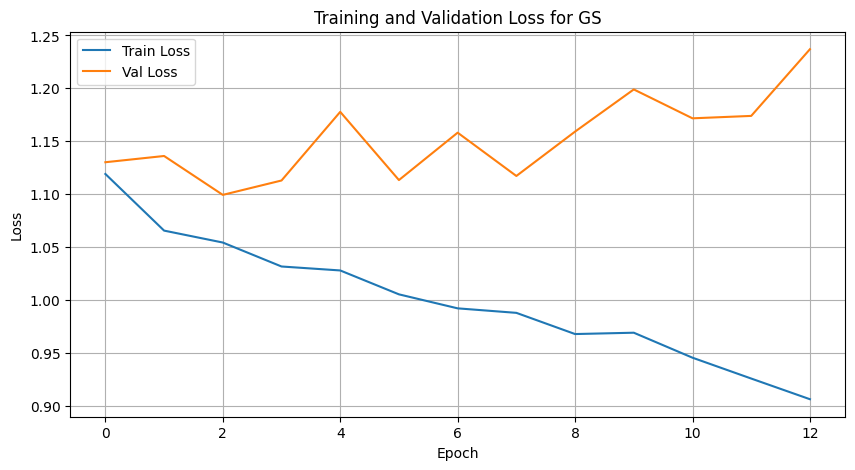


Loaded best model state with validation loss 1.0995.
  -> Model for GS saved to GS_transformer_model.pth

--- Processing WFC ---
  Original feature count: 1252
  Pre-filtered to 200 features for BorutaShap.

Applying BorutaShap for WFC using XGBoost on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

  - Features selected: 9
  BorutaShap selected too few features, falling back to top 30 correlated features.
  Training transformer for WFC...

Training WFC on cuda
 - Using class weights: [0.00177305 0.00072886 0.00147929]
Epoch 1/30, Train Loss: 1.1282, Val Loss: 1.1072, Epochs No Improve: 0
 -> Validation loss improved to 1.1072. Saving model.
Epoch 2/30, Train Loss: 1.0785, Val Loss: 1.0870, Epochs No Improve: 0
 -> Validation loss improved to 1.0870. Saving model.
Epoch 3/30, Train Loss: 1.0476, Val Loss: 1.0615, Epochs No Improve: 0
 -> Validation loss improved to 1.0615. Saving model.
Epoch 4/30, Train Loss: 1.0366, Val Loss: 1.1230, Epochs No Improve: 0
Epoch 5/30, Train Loss: 1.0104, Val Loss: 1.0789, Epochs No Improve: 1
Epoch 6/30, Train Loss: 0.9950, Val Loss: 1.0673, Epochs No Improve: 2
Epoch 7/30, Train Loss: 0.9698, Val Loss: 1.2559, Epochs No Improve: 3
Epoch 8/30, Train Loss: 0.9595, Val Loss: 1.2061, Epochs No Improve: 4
Epoch 9/30, Train Loss: 0.9330, Val Loss: 1.11

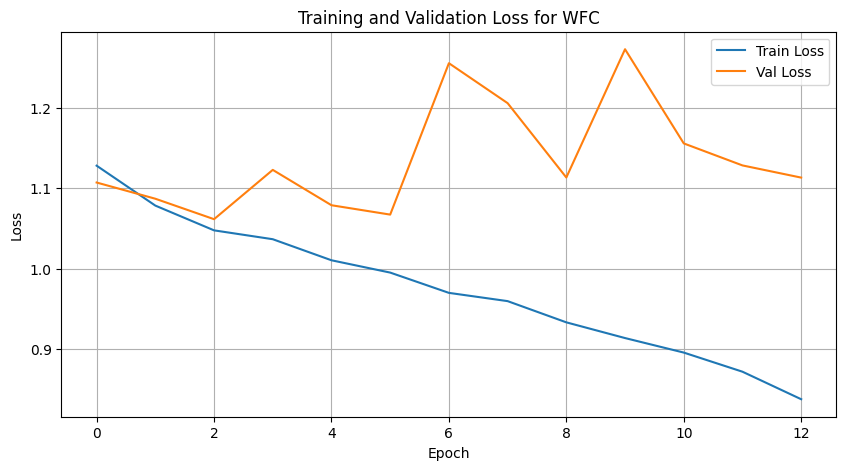


Loaded best model state with validation loss 1.0615.
  -> Model for WFC saved to WFC_transformer_model.pth

--- Processing MS ---
  Original feature count: 1252
  Pre-filtered to 200 features for BorutaShap.

Applying BorutaShap for MS using XGBoost on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

  - Features selected: 10
  Training transformer for MS...

Training MS on cuda
 - Using class weights: [0.00157729 0.00089686 0.00115875]
Epoch 1/30, Train Loss: 1.1235, Val Loss: 1.0955, Epochs No Improve: 0
 -> Validation loss improved to 1.0955. Saving model.
Epoch 2/30, Train Loss: 1.0704, Val Loss: 1.0870, Epochs No Improve: 0
 -> Validation loss improved to 1.0870. Saving model.
Epoch 3/30, Train Loss: 1.0522, Val Loss: 1.0935, Epochs No Improve: 0
Epoch 4/30, Train Loss: 1.0441, Val Loss: 1.1219, Epochs No Improve: 1
Epoch 5/30, Train Loss: 1.0304, Val Loss: 1.1114, Epochs No Improve: 2
Epoch 6/30, Train Loss: 1.0099, Val Loss: 1.1084, Epochs No Improve: 3
Epoch 7/30, Train Loss: 0.9868, Val Loss: 1.1129, Epochs No Improve: 4
Epoch 8/30, Train Loss: 0.9834, Val Loss: 1.1077, Epochs No Improve: 5
Epoch 9/30, Train Loss: 0.9605, Val Loss: 1.1335, Epochs No Improve: 6
Epoch 10/30, Train Loss: 0.9491, Val Loss: 1.1550, Epochs No Improve: 7
Epoch 11/30, Train Loss: 0.9403, Val Loss:

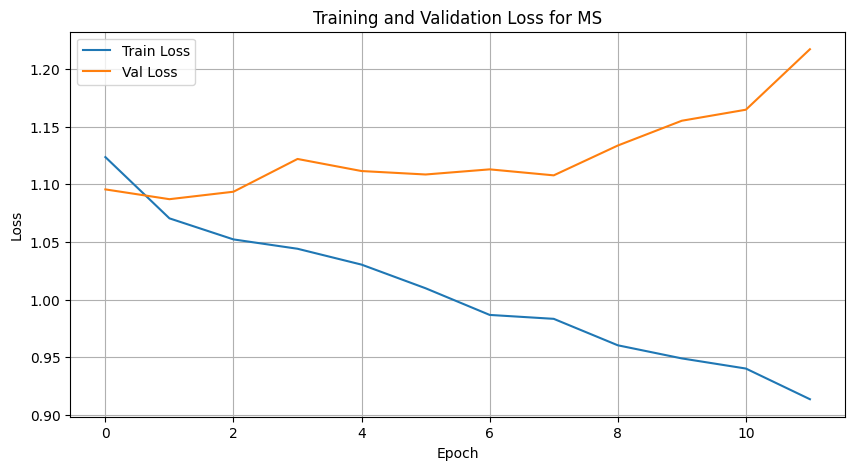


Loaded best model state with validation loss 1.0870.
  -> Model for MS saved to MS_transformer_model.pth

--- Processing AMZN ---
  Original feature count: 1252
  Pre-filtered to 200 features for BorutaShap.

Applying BorutaShap for AMZN using XGBoost on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

  - Features selected: 13
  Training transformer for AMZN...

Training AMZN on cuda
 - Using class weights: [0.00162075 0.00088731 0.00115207]
Epoch 1/30, Train Loss: 1.1016, Val Loss: 1.1001, Epochs No Improve: 0
 -> Validation loss improved to 1.1001. Saving model.
Epoch 2/30, Train Loss: 1.0615, Val Loss: 1.1177, Epochs No Improve: 0
Epoch 3/30, Train Loss: 1.0389, Val Loss: 1.1210, Epochs No Improve: 1
Epoch 4/30, Train Loss: 1.0204, Val Loss: 1.1754, Epochs No Improve: 2
Epoch 5/30, Train Loss: 1.0051, Val Loss: 1.1332, Epochs No Improve: 3
Epoch 6/30, Train Loss: 0.9917, Val Loss: 1.1553, Epochs No Improve: 4
Epoch 7/30, Train Loss: 0.9737, Val Loss: 1.1806, Epochs No Improve: 5
Epoch 8/30, Train Loss: 0.9541, Val Loss: 1.1994, Epochs No Improve: 6
Epoch 9/30, Train Loss: 0.9339, Val Loss: 1.1563, Epochs No Improve: 7
Epoch 10/30, Train Loss: 0.9172, Val Loss: 1.2153, Epochs No Improve: 8
Epoch 11/30, Train Loss: 0.9019, Val Loss: 1.2731, Epochs No Improve: 9

Early stopping trig

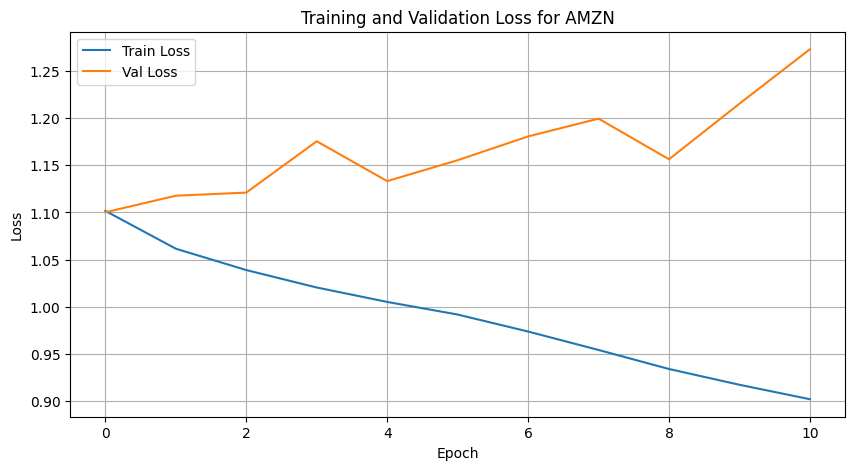


Loaded best model state with validation loss 1.1001.
  -> Model for AMZN saved to AMZN_transformer_model.pth

[Step 6] Backtesting strategy...

BACKTESTING STRATEGY

2024-01-02 Rebalancing... Current Equity: $1,000,000.00

2024-01-09 Rebalancing... Current Equity: $988,146.19

2024-01-17 Rebalancing... Current Equity: $995,306.28

2024-01-24 Rebalancing... Current Equity: $1,043,415.41

2024-01-31 Rebalancing... Current Equity: $1,061,739.11

2024-02-07 Rebalancing... Current Equity: $1,051,807.16

2024-02-14 Rebalancing... Current Equity: $1,056,809.74

2024-02-22 Rebalancing... Current Equity: $1,072,103.86

2024-02-29 Rebalancing... Current Equity: $1,065,850.19

2024-03-07 Rebalancing... Current Equity: $1,120,187.01

2024-03-14 Rebalancing... Current Equity: $1,128,750.33

2024-03-21 Rebalancing... Current Equity: $1,119,830.98

2024-03-28 Rebalancing... Current Equity: $1,092,836.91

2024-04-05 Rebalancing... Current Equity: $1,114,022.48

2024-04-12 Rebalancing... Current Equit

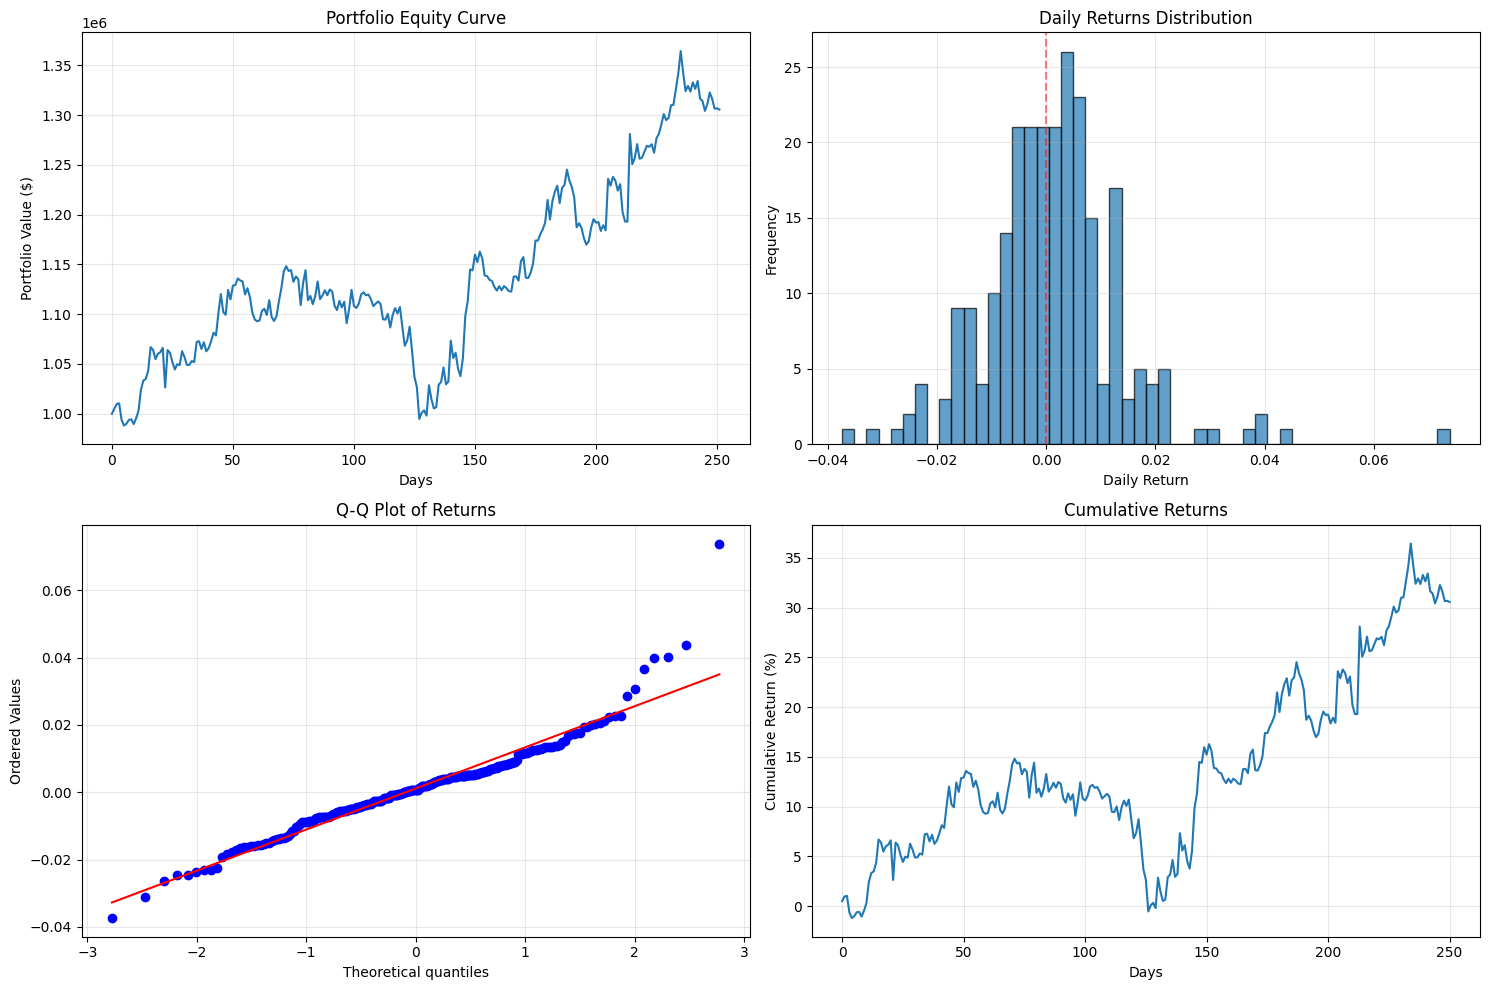


[Step 8] Generating current signals...

CURRENT TRADING SIGNALS
LONG positions (BUY):
  • JPM: Confidence 55.75%

SHORT positions (SELL):
  • GOOGL: Confidence 93.97%
  • TSLA: Confidence 63.01%
  • WFC: Confidence 59.52%
  • AMZN: Confidence 56.64%
  • GS: Confidence 48.67%

✅ Strategy execution completed!


In [ ]:









# ==========================================
# 10. MAIN EXECUTION PIPELINE
# ==========================================

def main():
    """
    Main execution pipeline for the complete, corrected strategy.
    """
    print("="*60)
    print("MULTI-STOCK LONG/SHORT TRANSFORMER STRATEGY")
    print("="*60)

    # --- Step 1: Fetch Data (Using a long history for robust training) ---
    print("\n[Step 1] Fetching historical data...")
    # Using a long history to train on multiple market cycles
    stocks_to_trade = ALL_STOCKS
    stock_data, spy, vix = fetch_all_stocks_data(
        stocks_to_trade,
        start_date='2004-01-01',
        end_date='2025-08-07', # Use yesterday's date or earlier
        use_alpha_vantage=True
    )

    # --- Step 2: Feature Engineering ---
    print("\n[Step 2] Creating features...")
    all_features = pd.DataFrame()
    for stock in stocks_to_trade:
        if stock in stock_data:
            print(f"  Processing features for {stock}...")
            stock_features = create_advanced_features(stock_data[stock], stock)
            all_features = pd.concat([all_features, stock_features], axis=1)

    market_features = create_market_features(spy, vix)
    all_features = pd.concat([all_features, market_features], axis=1)

    relative_features = create_relative_features(all_features, stocks_to_trade)
    all_features = pd.concat([all_features, relative_features], axis=1)

    # NEW, CORRECTED BLOCK
    # 1. Interpolate to fill internal gaps with a straight line.
    all_features = all_features.interpolate(method='linear')
    # 2. Forward-fill to handle any remaining NaNs (e.g., at the very start).
    all_features = all_features.fillna(method='ffill')
    # 3. Back-fill as a final safety net.
    all_features = all_features.fillna(method='bfill')
    # 4. Any NaNs left would mean an entire column is empty, so drop it.
    all_features.dropna(axis=1, inplace=True)
    print(f"  Total features created: {all_features.shape[1]}")

    # --- Step 3: Create Targets & Align Data ---
    print("\n[Step 3] Creating targets and aligning data...")
    targets = create_targets(stock_data, stocks_to_trade, forward_days=5)

    common_index = all_features.index.intersection(targets.index)
    all_features = all_features.loc[common_index]
    targets = targets.loc[common_index]
    print(f"  Data aligned to {len(common_index)} common dates.")

    # --- Step 4: Split Data ---
    print("\n[Step 4] Splitting data...")
    train_end = '2022-12-31'
    val_end = '2023-12-31'

    train_features = all_features.loc[:train_end]
    val_features = all_features.loc[train_end:val_end]
    test_features = all_features.loc[val_end:]

    train_targets = targets.loc[:train_end]
    val_targets = targets.loc[train_end:val_end]

    print(f"  Train: {len(train_features)} samples")
    print(f"  Validation: {len(val_features)} samples")
    print(f"  Test: {len(test_features)} samples")

    # --- Step 5: Feature Selection and Model Training ---
    print("\n[Step 5] Training models for each stock...")
    models = {}
    selected_features_dict = {}
    scalers = {}
    feature_importances = {} # Dictionary to store feature importances
    sequence_length = 60

    for stock in stocks_to_trade:
        print(f"\n--- Processing {stock} ---")

        if f'{stock}_signal' in train_targets.columns:
            X_train_stock = train_features
            y_train_stock = train_targets[f'{stock}_signal'].values
            X_val_stock = val_features
            y_val_stock = val_targets[f'{stock}_signal'].values

            print(f"  Original feature count: {X_train_stock.shape[1]}")
            correlations = X_train_stock.corrwith(pd.Series(y_train_stock)).abs().sort_values(ascending=False)
            top_features = correlations.nlargest(200).index.tolist()
            X_train_stock_filtered = X_train_stock[top_features]
            print(f"  Pre-filtered to {len(top_features)} features for BorutaShap.")

            try:
                # Apply BorutaShap and capture feature importances
                selected_features, selector, importance_df = apply_boruta_shap(
                    X_train_stock_filtered.iloc[sequence_length:],
                    y_train_stock[sequence_length:],
                    stock
                )

                feature_importances[stock] = importance_df

                if len(selected_features) < 10:
                    print("  BorutaShap selected too few features, falling back to top 30 correlated features.")
                    selected_features = top_features[:30]

                selected_features_dict[stock] = selected_features

                scaler = RobustScaler()
                X_train_scaled = scaler.fit_transform(X_train_stock[selected_features])
                X_val_scaled = scaler.transform(X_val_stock[selected_features])
                scalers[stock] = scaler

                X_train_seq, y_train_seq = prepare_sequences(X_train_scaled, y_train_stock, sequence_length)
                X_val_seq, y_val_seq = prepare_sequences(X_val_scaled, y_val_stock, sequence_length)

                print(f"  Training transformer for {stock}...")
                model, train_losses, val_losses = train_transformer(
                    X_train_seq, y_train_seq,
                    X_val_seq, y_val_seq,
                    input_dim=len(selected_features),
                    y_train_full=y_train_stock,
                    stock=stock,
                    epochs=30,
                    batch_size=32
                )
                models[stock] = model
                model_save_path = f"{stock}_transformer_model.pth"
                torch.save(model.state_dict(), model_save_path)
                print(f"  -> Model for {stock} saved to {model_save_path}")

            except Exception as e:
                print(f"  Error training {stock}: {e}")
                continue

    # --- Step 6: Backtest Strategy ---
    print("\n[Step 6] Backtesting strategy...")
    backtest_results = backtest_strategy(
        stock_data, models, selected_features_dict, scalers, stocks_to_trade,
        test_start='2024-01-01', test_end='2024-12-31'
    )

    # --- Step 7: Visualize Results ---
    if backtest_results:
        print("\n[Step 7] Creating visualizations...")
        plot_backtest_results(backtest_results, spy, backtest_results['test_dates'])

    # --- Step 8: Generate Current Signals ---
    print("\n[Step 8] Generating current signals...")
    if models:
        portfolio = LongShortPortfolio(models, selected_features_dict, scalers, list(models.keys()))
        current_predictions = portfolio.predict_signals(all_features, sequence_length)
        long_stocks, short_stocks = portfolio.select_top_positions(current_predictions, num_long=5, num_short=5)

        print("\n" + "="*60)
        print("CURRENT TRADING SIGNALS")
        print("="*60)
        print(f"LONG positions (BUY):")
        for stock in long_stocks:
            confidence = current_predictions.get(stock, {}).get('confidence', 0)
            print(f"  • {stock}: Confidence {confidence:.2%}")

        print(f"\nSHORT positions (SELL):")
        for stock in short_stocks:
            confidence = current_predictions.get(stock, {}).get('confidence', 0)
            print(f"  • {stock}: Confidence {confidence:.2%}")

    return backtest_results, models, selected_features_dict, feature_importances

if __name__ == "__main__":
    # Ensure you have run the !pip install --upgrade BorutaShapPlus command
    results, models, features, importances = main()
    print("\n✅ Strategy execution completed!")